In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import pathlib
import seaborn as sns
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pybedtools
from amb import *
import seaborn  as sns
from amb import *
import numpy as np
import joblib
import pyBigWig

In [2]:
use_cts = ['Oligo_NN', 'CA1-ProS_Glut', 'L5_IT_CTX_Glut', 'DG_Glut', 'L6_IT_CTX_Glut', 'L5_ET_CTX_Glut', 
           'CA3_Glut',  'L45_IT_CTX_Glut', 'LA-BLA-BMA-PA_Glut']

In [3]:
admr_dir = 'mC_FILTER_DMR_BED/'

mc_to_atac = {'Oligo_NN':'Oligo_NN',
             'CA1-ProS_Glut': 'CA1-ProS_Glut',
             'L5_IT_CTX_Glut': 'L5_IT_CTX_Glut',
             'DG_Glut': 'DG_Glut',
             'L6_IT_CTX_Glut': 'L6_IT_CTX_Glut',
             'L5_ET_CTX_Glut': 'L5_ET_CTX_Glut',
             'CA3_Glut': 'CA3_Glut',
             'L23_IT_PPP_Glut':'L2_IT_PPP-APr_Glut',
             'ENTmv-PA-COAp_Glut': 'ENTmv-PA-COAp_Glut',
             'L45_IT_CTX_Glut':'L5_IT_CTX_Glut',
             'LA-BLA-BMA-PA_Glut': 'LA-BLA-BMA-PA_Glut'}


In [4]:
all_beds = []

for ct in use_cts:
    path = f"{admr_dir}/{ct}.Hypo.aDMR.bed"
    tmpdf = pd.read_csv(path, sep = '\t', header = None)
    tmpdf['celltype'] = ct
    tmpdf = tmpdf[tmpdf[0] != 'chrX'][[3, 'celltype']]
    if tmpdf.shape[0] > 100:
        tmpdf = tmpdf.sample(100)
    else:
        tmpdf = tmpdf
    all_beds.append(tmpdf)

all_beds = pd.concat(all_beds, axis = 0).set_index(3)
duplicated_indices = all_beds.index.duplicated(keep=False)
all_beds = all_beds[~duplicated_indices]

dmr_list = all_beds.index

In [5]:
# get aDMR atac counts
bigwig_dir = '/ceph/gale-1/qzeng/AmbData/Luisa/male_atac'

def get_atac_counts(age, atac_ct, dmr_list):
    bigwig_path = f"{bigwig_dir}/Male_{atac_ct}_{age}_merge.bw"
    bw = pyBigWig.open(bigwig_path)
    total_counts = []
    for dmr_id in dmr_list:
        slop = 300
        _chr, start, end = dmr_id.split('-')
        start, end = int(start)-slop, int(end) + slop
        counts = bw.stats(_chr, start, end, type="sum")[0]
        total_counts.append(counts)
    tmpdf = pd.DataFrame({age:total_counts}, index = dmr_list)
    return tmpdf


In [6]:
age_list = ['2mo','18mo']
all_use_dmrs = []
all_counts_df = []

for ct in use_cts:
    ct_counts = []
    atac_ct = mc_to_atac[ct]
    for age in age_list:
        tmpdf = get_atac_counts(age, atac_ct, dmr_list)
        ct_counts.append(tmpdf)
    
    ct_counts = pd.concat(ct_counts, axis = 1)
    ct_counts = ct_counts.div(ct_counts.sum(axis = 1), axis = 0).fillna(0)
    ct_counts['change'] = ct_counts['18mo'] - ct_counts['2mo']
    ct_counts = ct_counts[['change']]
    
    
    ct_counts.columns = [atac_ct]
    all_counts_df.append(ct_counts)


all_counts_df = pd.concat(all_counts_df, axis = 1)
all_counts_df.head()

,Oligo_NN,CA1-ProS_Glut,L5_IT_CTX_Glut,DG_Glut,L6_IT_CTX_Glut,L5_ET_CTX_Glut,CA3_Glut,L5_IT_CTX_Glut,LA-BLA-BMA-PA_Glut
3,,,,,,,,,
chr11-113138687-113138714,0.180777,0.264000,0.165274,0.138251,-0.005784,-0.330143,-0.116735,0.165274,-0.052247
chr13-80940543-80940574,0.040530,-0.297160,-0.132594,-0.218104,-0.175012,-0.588193,0.208598,-0.132594,-0.501648
chr8-10959005-10959178,0.108305,0.708113,-0.131894,-0.153050,0.000000,0.065742,0.495771,-0.131894,-1.000000
chr7-139580679-139580806,0.051854,0.117427,-0.052179,0.015734,-0.040848,-0.085747,0.024969,-0.052179,-0.141356
chr19-41075358-41075689,-0.068874,-0.230806,-0.133761,-0.288958,-0.338610,0.174289,0.190267,-0.133761,0.101445


## plot heatmap

In [7]:
import PyComplexHeatmap as pch
from PyComplexHeatmap import *
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=100
plt.rcParams['pdf.fonttype']=42

In [8]:
import joblib
mt_pelatte = joblib.load('/home/qzeng/project/aging/231117_update_annot/AgingMajorType_Palette')

new_mt_palette = {}
for mt ,_color in mt_pelatte.items():
    mt= mt.replace('/','').replace(' ','_')
    new_mt_palette[mt] = _color

In [9]:
# use_counts_df = all_counts_df.loc[ordered_all_use_dmrs]
# row_annot = all_beds.loc[ordered_all_use_dmrs]

In [10]:
row_annot = all_beds
row_annot.head()

,celltype
3,
chr11-113138687-113138714,Oligo_NN
chr13-80940543-80940574,Oligo_NN
chr8-10959005-10959178,Oligo_NN
chr7-139580679-139580806,Oligo_NN
chr19-41075358-41075689,Oligo_NN


In [11]:
left_ha = pch.HeatmapAnnotation(
                          label=pch.anno_label(row_annot.celltype,merge=True,extend=False,colors = new_mt_palette,
                                               adjust_color=True,luminance=0.75,relpos=(1,0.5)),
                           CellType=pch.anno_simple(row_annot.celltype,legend=True,colors= new_mt_palette),
                           verbose=1,axis=0,plot_legend=False)

In [12]:
from scipy.stats import zscore
all_counts_df_zscore = all_counts_df.apply(zscore)
all_counts_df_zscore.head()

,Oligo_NN,CA1-ProS_Glut,L5_IT_CTX_Glut,DG_Glut,L6_IT_CTX_Glut,L5_ET_CTX_Glut,CA3_Glut,L5_IT_CTX_Glut,LA-BLA-BMA-PA_Glut
3,,,,,,,,,
chr11-113138687-113138714,0.956401,0.804402,0.473539,0.525585,-0.049363,-0.974023,-0.410300,0.473539,-0.211978
chr13-80940543-80940574,0.414903,-1.326978,-0.749486,-1.037143,-0.414808,-1.674814,0.642229,-0.749486,-1.585613
chr8-10959005-10959178,0.676582,2.491222,-0.746613,-0.751861,-0.036872,0.101089,1.571304,-0.746613,-3.108869
chr7-139580679-139580806,0.458624,0.247693,-0.419307,-0.011690,-0.125084,-0.310311,0.048145,-0.419307,-0.484348
chr19-41075358-41075689,-0.007512,-1.074957,-0.754279,-1.347861,-0.768098,0.395871,0.582925,-0.754279,0.257795


In [13]:
np.percentile(all_counts_df_zscore.values, 90)

1.019691556191854

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


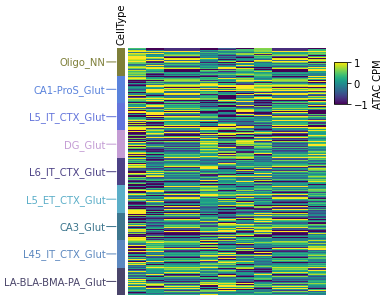

In [15]:
plt.figure(figsize=(4, 4))
value = 1
cm = ClusterMapPlotter(
        data= all_counts_df_zscore, 
        fmt=None,
        top_annotation=None,left_annotation=left_ha,
        vmin = -value, vmax = value,
        col_cluster=False,row_cluster=False,
        label = 'ATAC CPM',z_score = None,
        cmap='viridis',rasterized=True,
        # xticklabels_kws={'labelrotation':0,'labelcolor':'blue'}
        )
#plt.savefig(f"figure/{_type}.PycomplexClustertmap.pdf", bbox_inches='tight')
plt.show()